In [1]:
# Load in training dataset (Airline sentiment tweet data)
import pandas as pd
import numpy as np
from datasets import load_dataset

airline_df = pd.read_csv("hf://datasets/osanseviero/twitter-airline-sentiment/Tweets.csv")

### Dataset Description: Twitter Airline Sentiment
The Twitter Airline Sentiment dataset originally came from Crowdflower's "Data for Everyone" library. It was originally created for a sentiment analysis, specifically in an attempt to find problems that customers noticed with each airline in the dataset.  Contributors were asked to classify the tweets as positive, neutral, or negative, and also asked to explain what issue was present in a tweet if it was negative (ex: "delayed flight"). Each tweet is also recorded with data like when it was created, the user who created the tweet, the sentiment label given to the tweet, and the airline the tweet is associated with.

There are 14,640 tweets total in the dataset, and the tweets were scraped from the time period of February 16th, 2015 to February 24th, 2015. The average tweet length in the dataset is 19.12 words. 

We will be using this dataset to train our sentiment classification models.

Tweet distribution per airline:
United: 3822 || US Airways: 2913 || American: 2759 || Southwest: 2420 || Delta: 2222 || Virgin America: 504 

Tweet distrubtion per sentiment:
Negative: 9178 || Neutral: 3099 || Positive: 2363

In [2]:
# load twitter dataset into pandas 
from nltk.tokenize import TweetTokenizer 

print(airline_df.shape)
print(min(airline_df['tweet_created'])) # Find earliest tweet for dataset
print(max(airline_df['tweet_created'])) # Find earliest tweet for dataset

print(set(airline_df['airline'])) # Find the unique airlines

# Get airline tweet counts
print()
print("Tweet counts for airlines")
print(airline_df['airline'].value_counts())
print()


# Get airline sentiment counts
print("Sentiment frequency")
print(airline_df['airline_sentiment'].value_counts())
print() 

# Method for removing the "@airline" token from a tweet
def _remove_airline_tok(tokens):
    return tokens[1:] if tokens[0].startswith('@') else tokens   

tokenizer = TweetTokenizer()

# Tokenize tweet text
tweet_text = airline_df["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
clean_tweets = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]
    
# Find the average length of tweets
len_arr = []
for tweet in clean_tweets:
    tweet_length = len(tweet)
    len_arr.append(tweet_length)
tweet_mean = np.mean(len_arr)
print("Average length of tweets:", tweet_mean)
    

(14640, 15)
2015-02-16 23:36:05 -0800
2015-02-24 11:53:37 -0800
{'United', 'US Airways', 'Virgin America', 'Delta', 'Southwest', 'American'}

Tweet counts for airlines
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Sentiment frequency
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Average length of tweets: 19.122677595628414


In [3]:
# display(airline_df)

In [4]:
# Helpful resource for multinomial regression: 
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split the airline data into training and test splits

air_feats = airline_df["text"]
air_labels = airline_df["airline_sentiment"]

feat_train, feat_test, label_train, label_test = train_test_split(air_feats, air_labels, test_size = 0.8)

# Tokenize the airline tweets in either split

def _remove_airline_tok(tokens):
    return tokens[1:] if tokens[0].startswith('@') else tokens    

tokenizer = TweetTokenizer()

#Tokenizing training airline tweets
train_tweets = feat_train.values
train_tweets_tokenized = [tokenizer.tokenize(tweet) for tweet in train_tweets]
train_tweets_clean = [_remove_airline_tok(tokens) for tokens in train_tweets_tokenized]

#Tokenizing testing airline tweets
test_tweets = feat_test.values
test_tweets_tokenized = [tokenizer.tokenize(tweet) for tweet in test_tweets]
test_tweets_clean = [_remove_airline_tok(tokens) for tokens in test_tweets_tokenized]


In [5]:
# loading word2vec vectors

# Useful resource on word2vec 
# https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca

import os
from gensim.models import KeyedVectors

w2v_file = 'GoogleNews-vectors-negative300.bin.gz'
w2v_file = os.path.expanduser(w2v_file)


w2v_vectors = KeyedVectors.load_word2vec_format(w2v_file, binary=True)
print('done loading.')

done loading.


In [6]:
# Training multinomial regression using word2vec vectors

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

# Helpful guide: https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca



# Function for creating the average word2vec vector for each tweet 
def tweet_to_avg_vector(tweet_tokens):
    vectors = []
    for word in tweet_tokens:
        if word in w2v_vectors:
            vectors.append(w2v_vectors[word])
        else:
            vectors.append(np.zeros(300))  # If word is not in word2Vec, use zero vector
    return np.mean(vectors, axis=0)  # Average word vectors to represent the whole sentence 

# Convert training tweets to their average Word2Vec vector representations
x_train_vectors = np.array([tweet_to_avg_vector(tweet) for tweet in train_tweets_clean])


# Convert testing tweets to their average Word2Vec vector representations
x_test_vectors = np.array([tweet_to_avg_vector(tweet) for tweet in test_tweets_clean])




# Train a multinomial logistic regression model (using word2vec vectors)
mr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
mr.fit(x_train_vectors, label_train)

# Get predictions then evaluate performance on test set
label_pred = mr.predict(x_test_vectors)
print(classification_report(label_test, label_pred))



              precision    recall  f1-score   support

    negative       0.78      0.95      0.85      7367
     neutral       0.64      0.39      0.48      2462
    positive       0.81      0.51      0.62      1883

    accuracy                           0.76     11712
   macro avg       0.74      0.62      0.65     11712
weighted avg       0.75      0.76      0.74     11712



In [7]:
# Training multinomial regression using TF-IDF vectors 

# Get TF-IDF vectors after tokenizing
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()

# Convert tokenized tweets into strings that tf-idf vectorizer can actually use
train_tweets_clean_joined = [' '.join(tokens) for tokens in train_tweets_clean]
test_tweets_clean_joined = [' '.join(tokens) for tokens in test_tweets_clean]

train_tweets_tfidf = vectorizer.fit_transform(train_tweets_clean_joined)
test_tweets_tfidf = vectorizer.transform(test_tweets_clean_joined)


# Train a multinomial logistic regression model
mr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
mr.fit(train_tweets_tfidf, label_train)

# Get predictions then evaluate performance on test set
label_pred = mr.predict(test_tweets_tfidf)
print(classification_report(label_test, label_pred))

from sklearn.metrics import f1_score

              precision    recall  f1-score   support

    negative       0.75      0.96      0.84      7367
     neutral       0.68      0.37      0.48      2462
    positive       0.84      0.43      0.57      1883

    accuracy                           0.75     11712
   macro avg       0.76      0.59      0.63     11712
weighted avg       0.75      0.75      0.72     11712



In [8]:
"""
              

word2vec:
              precision    recall  f1-score   support

    negative       0.77      0.96      0.85      7333
     neutral       0.67      0.36      0.47      2471
    positive       0.82      0.50      0.62      1908

    accuracy                           0.76     11712
   macro avg       0.75      0.61      0.65     11712
weighted avg       0.75      0.76      0.74     11712


tf-idf:
              precision    recall  f1-score   support

    negative       0.75      0.97      0.84      7333
     neutral       0.68      0.35      0.46      2471
    positive       0.84      0.42      0.56      1908

    accuracy                           0.75     11712
   macro avg       0.76      0.58      0.62     11712
weighted avg       0.75      0.75      0.72     11712
"""

'\n              \n\nword2vec:\n              precision    recall  f1-score   support\n\n    negative       0.77      0.96      0.85      7333\n     neutral       0.67      0.36      0.47      2471\n    positive       0.82      0.50      0.62      1908\n\n    accuracy                           0.76     11712\n   macro avg       0.75      0.61      0.65     11712\nweighted avg       0.75      0.76      0.74     11712\n\n\ntf-idf:\n              precision    recall  f1-score   support\n\n    negative       0.75      0.97      0.84      7333\n     neutral       0.68      0.35      0.46      2471\n    positive       0.84      0.42      0.56      1908\n\n    accuracy                           0.75     11712\n   macro avg       0.76      0.58      0.62     11712\nweighted avg       0.75      0.75      0.72     11712\n'

### TF-idf or word2vec (airline data)?

#### Word2vec
Per class performance of the multinomial regression model trained on word2vec:
Negative: Precision = 0.77 || Recall = 0.96 || F1-score = 0.85
Neutral: Precision = 0.67 || Recall = 0.36 || F1-score = 0.47
Positive: Precision = 0.82 || Recall = 0.50 || F1-score = 0.62

The airline dataset is imbalanced with a lot of negative tweets, and the model seems to have gotten better at classifying negative tweets than neutral or positive ones. Looking at the recall scores specifically, we can see that the model correctly classied 96% of the negative tweets, but much lower for the neutral (36%) and positive (50%) tweets. This is reflected in the per-class F1 scores as well, with the negative class F1 score being at a solid 0.85, while the neutral (0.47) and positive (0.62) F1 scores are much lower.

The average accuracy of the multinomial regression model trained on word2vec vectors is 0.76. The macro-averaged F1-score is 0.65, while the micro-averaged F1-score is 0.74. This makes sense, as the higher number of negative tweets and the model's superior performance on those negative tweets would bring the micro-F1 up, while the macro-F1 reflects that it did worse on classifying neutral and positive tweets.


#### TF-idf

Per class performance of the multinomial regression model trained on TF-idf vectors:
Negative: Precision = 0.75 || Recall = 0.97 || F1-score = 0.84
Neutral: Precision = 0.68 || Recall = 0.35 || F1-score = 0.46
Positive: Precision = 0.84 || Recall = 0.42 || F1-score = 0.57

Again, the imbalance in the distribution of sentiments in the tweets is visible here. The model performed better on negative tweets (F1-score: 0.84) than it did on neutral (F1-score: 0.46) or positive tweets (F1-score: 0.57). Additionally, we can see the same pattern where the micro-F1 score, which gives equal weight to all instances, is biased by the high number of negative tweets and sits at 0.72 while the macro-average, which gives equal weight to all classes, is lower at 0.62.

Comparing the averages between the two models, it seems that word2vec performs slightly better but it's a small difference and word2vec takes much longer to run, so I'd just stick to using the TF-idf vectors.

In [9]:
# Load in the main Twitter corpus
twitter_df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding ="latin-1", 
                         names=["sentiment", "id", "date", "flag", "user", "text"])


In [10]:
print(twitter_df.shape)
display(twitter_df)

(1600000, 6)


,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Dataset Description: Twitter Sentiment140
The Sentiment140 dataset is a dataset of Tweets that was collected as part of a research paper which can be found at this link: (https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf).

The original use of the dataset was test how machine learning models would perform when classifying the sentiment of Tweets when trained on data including emoticons like ":)". Rather than hand-labeling data, they used the emoticons as a noisy label for the sentiment of each tweet. Tweets with emoticons like ":)" were labeled as containing positive sentiment, while tweets with emoticons like ":(" were labeled as negative. 

The Tweets were gathered through various queries using Twitter's API, and tweets containing both positive and negative emoticons were removed from the dataset. Each tweet is also recorded with data like when it was created, the user who created the tweet, the sentiment label given to the tweet, and the query used to find the tweet, if any.

There are 1,600,000 Tweets in the dataset, and there are tweets from 659,775 different users. The tweets are taken from the time period of April 17th, 2009 to May 27th, 2009. The distribution of sentiments is even, with 800,000 positive tweets and 800,000 negative tweets. The average length of tweets in the corpus is 14.85 words.

We will be using this dataset as the corpus we're analyzing.

##### Note: Realized Kaggle tricked me because the Sentiment140 dataset page had a note that said "target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)" but there are actually only positive / negative labels in the dataset.

In [11]:
# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

# Create function to convert numerical sentiment labels into text
def map_sentiment(value):
    if value == 0:
        return 'negative'
    elif value == 2:
        return 'neutral'
    elif value == 4:
        return 'positive'

twitter_df["sentiment_text"] = twitter_df["sentiment"].apply(map_sentiment)

In [12]:
# print(twitter_df["sentiment"].head(-40))
# print(twitter_df["sentiment_text"].head(-40))

In [13]:
print(min(twitter_df['date'])) # Find earliest tweet for dataset
print(max(twitter_df['date'])) # Find earliest tweet for dataset

# Find number of different users in the dataset
unique_users = set(twitter_df["user"])
unique_user_count = len(unique_users)
print("Unique user count:", unique_user_count)

# Get frequency of each sentiment
print("Sentiment frequency")
print(twitter_df['sentiment'].value_counts())
print() 

tokenizer = TweetTokenizer()

# Tokenize tweet text
# also removing the "@person" token from a tweet; cleans up any tweets that are replies to other users
tweet_text = twitter_df["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
clean_tweets = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]
    
# Find the average length of tweets
len_arr = []
for tweet in clean_tweets:
    tweet_length = len(tweet)
    len_arr.append(tweet_length)
tweet_mean = np.mean(len_arr)
print("Average length of tweets:", tweet_mean)
    

Fri Apr 17 20:30:31 PDT 2009
Wed May 27 07:27:38 PDT 2009
Unique user count: 659775
Sentiment frequency
0    800000
4    800000
Name: sentiment, dtype: int64

Average length of tweets: 14.852441875


In [14]:
# NER entity types:
# PERSON:      People, including fictional.
# NORP:        Nationalities or religious or political groups.
# FAC:         Buildings, airports, highways, bridges, etc.
# ORG:         Companies, agencies, institutions, etc.
# GPE:         Countries, cities, states.
# LOC:         Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
# EVENT:       Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART: Titles of books, songs, etc.
# LAW:         Named documents made into laws.
# LANGUAGE:    Any named language.
# DATE:        Absolute or relative dates or periods.
# TIME:        Times smaller than a day.
# PERCENT:     Percentage, including ”%“.
# MONEY:       Monetary values, including unit.
# QUANTITY:    Measurements, as of weight or distance.
# ORDINAL:     “first”, “second”, etc.
# CARDINAL:    Numerals that do not fall under another type.

In [15]:
# Time for NER!

# Load spacy models and using for NER
import spacy

# load a spacy model trained on web text
nlp_web = spacy.load("en_core_web_sm")


doc_web = twitter_df['text'].apply(nlp_web) # Apply nlp web to each row in the ['document'] series


In [16]:
def extract_entities(doc): # Function for getting the entity text + entity labels for each doc 
    return [(ent.text, ent.label_) for ent in doc.ents]

entities = doc_web.apply(extract_entities)
display(entities)

0          [(@switchfoot http://twitpic.com/2y1zl -, PERS...
1                                            [(School, ORG)]
2                                           [(50%, PERCENT)]
3                                                         []
4                                                         []
                                 ...                        
1599995                                                   []
1599996                                     [(Walt, PERSON)]
1599997                                                   []
1599998      [(38th, ORDINAL), (Tupac Amaru Shakur, PERSON)]
1599999                                      [(#, CARDINAL)]
Name: text, Length: 1600000, dtype: object

In [17]:
entity_sum = 0
for doc in entities:
    entity_count = len(doc)
    entity_sum += entity_count
    
entity_avg = entity_sum / len(entities)
print("Average number of entities per tweet:", entity_avg)


# Now find total number of each entity type
from collections import Counter


# Function to count entity types in a single document
def count_entity_types(doc):
    entity_types = [ent.label_ for ent in doc.ents]
    return Counter(entity_types)

entity_counts = doc_web.apply(count_entity_types)

# Convert to dataframe to make summarizing easier
entity_counts_df = pd.DataFrame(list(entity_counts))

# Find the sum of instances for each entity type
sum_entity_counts = entity_counts_df.sum()

print(sum_entity_counts)


Average number of entities per tweet: 0.934395625
PERSON         344579.0
DATE           291742.0
ORG            305084.0
PERCENT          2850.0
ORDINAL         26742.0
CARDINAL       158404.0
LOC             11457.0
TIME           114966.0
GPE            138184.0
NORP            36439.0
QUANTITY         5938.0
WORK_OF_ART     12484.0
FAC              8745.0
MONEY           13660.0
PRODUCT         16398.0
LANGUAGE         3032.0
EVENT            2842.0
LAW              1487.0
dtype: float64


In [18]:
entity_labels = ['PERSON', 'DATE', 'ORG', 'PERCENT', 'ORDINAL', 'CARDINAL', 'LOC', 'TIME', 'GPE', 'NORP', 'QUANTITY',
                 'WORK_OF_ART', 'FAC', 'MONEY', 'PRODUCT', 'LANGUAGE', 'EVENT', 'LAW']

# Dictionary to store counts for each type
entity_spans = {label: Counter() for label in entity_labels}

# Iterate over each document then count spans
for doc in doc_web:
    for ent in doc.ents:
        entity_spans[ent.label_].update([ent.text]) 


# Helpful guide on using items() to iterate through keys+values in a dict: 
# https://www.geeksforgeeks.org/iterate-over-a-dictionary-in-python/
# Finding most common item in a list:
# https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
most_common_ents = {}
for entity, spans in entity_spans.items():
    if spans:  # Confirm there are named entities in the doc
        
        #Only shows the top 1 most common span
        #most_common_span, count = spans.most_common(1)[0]  # Get the most common span and its count
        #most_common_ents[entity] = (most_common_span, count)  # Add it to the result dictionary
        
        # Show top 3 common spans
        most_common_spans = spans.most_common(3)  # Get the top 3 most common spans and their counts
        most_common_ents[entity] = most_common_spans  # Add them to the result dictionary
    
    
# Print the most common span for each entity type
# for entity, (span, count) in most_common_ents.items():
#     print(entity + ": Most common span = " + span + " ("+ str(count) + " instances)")
    
# Print the top 3 most common spans for each entity type
for entity, common_spans in most_common_ents.items():
    print(entity + ": ")
    for span, count in common_spans:
        print(f"  - {span}: {count} instances")

PERSON: 
  - Twitter: 3712 instances
  - Lol: 1917 instances
  - @ddlovato: 1636 instances
DATE: 
  - today: 57597 instances
  - tomorrow: 27349 instances
  - yesterday: 8535 instances
ORG: 
  - LOL: 8055 instances
  - iPod: 1262 instances
  - LOVE: 1146 instances
PERCENT: 
  - 100%: 587 instances
  - 50%: 134 instances
  - 10%: 124 instances
ORDINAL: 
  - first: 12105 instances
  - second: 2461 instances
  - 1st: 1539 instances
CARDINAL: 
  - 2: 25610 instances
  - one: 14757 instances
  - 4: 9613 instances
LOC: 
  - NYC: 1093 instances
  - Europe: 512 instances
  - new moon: 299 instances
TIME: 
  - tonight: 23124 instances
  - last night: 9733 instances
  - morning: 8907 instances
GPE: 
  - London: 1901 instances
  - LA: 1891 instances
  - UK: 1883 instances
NORP: 
  - french: 1109 instances
  - english: 775 instances
  - Congrats: 630 instances
QUANTITY: 
  - a ton: 273 instances
  - a mile: 73 instances
  - 100 degrees: 57 instances
WORK_OF_ART: 
  - Love: 2551 instances
  - Star 

### Baseline entity analysis across all tweets 
There are 0.93 entities in each tweet, on average. The most common type of entity is "PERSON" (344,579 tweets), followed by "ORG" (305,084 tweets), and "DATE" (291,742) tweets. The least common entity types are "LAW" (1,487 tweets), "EVENT" (2,842 teets), and "PERCENT" (2,850 tweets).

The most common spans per entity type are as follows:
- PERSON: "Twitter", "Lol", and "@ddlovato"
- DATE: "Today", "tomorrow", and "yesterday"
- ORG: "LOL", "iPod", and "LOVE"
- PERCENT: "100%", "50%", and "10%"
- ORDINAL: "first", "second", and "1st"
- CARDINAL: "2", "one", and "4"
- LOC: "NYC", "Europe", and "new moon"
- TIME: "tonight", "last night", and "morning"
- GPE: "London", "LA", and "UK"
- NORP: "french", "english", and "Congrats"
- QUANTITY: "a ton", "a mile", and "100 degrees"
- WORK_OF_ART: "Love", "Star Trek" and "LoL"
- FAC: "Disneyland", "metro", and "True Blood"
- MONEY: "#fb", "1", and "2"
- PRODUCT: "Twitter", "â¥", and "Magic"
- LANGUAGE: "English", "english", "French"
- EVENT: "Wimbledon", "the French Open", "@gfalcone601"
- LAW: "TONS", "Thnx 4", "ï¿½"

We can see that there are some interesting parts of these results, like the NER algorithm treating "English" and "english" as different languages, or treating "English" and "english" as different languages, though we can't just remove all capitalization as I'm sure that plays a role in helping the NER model to decide what is or isn't an entity. We can definitely see that these entites were pulled from the past. Entitiesl like "iPod" and "@ddlovato" (Demi Lovato) are definitely less culturally relevant now!

In [19]:
# Get a random sample of 1000 rows to test code without taking forever
# corpus_sample = twitter_df.sample(n=1000) 
# For full dataset, use "twitter_df" instead to replace "corpus_sample"

####
# Tokenize tweet text
tweet_text = twitter_df["text"].values  
# tweet_text = corpus_sample["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
corpus_tweets_clean = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]

# Convert tokenized tweets into strings that tf-idf vectorizer can actually use
corpus_tweets_clean_joined = [' '.join(tokens) for tokens in corpus_tweets_clean]
####

# train_tweets_tfidf = vectorizer.fit_transform(train_tweets_clean_joined)
corpus_tweets_tfidf = vectorizer.transform(corpus_tweets_clean_joined)


# Get predictions then evaluate performance on test set
corpus_label_pred = mr.predict(corpus_tweets_tfidf)
print(classification_report(twitter_df["sentiment_text"], corpus_label_pred))


C:\Users\tduon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tduon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.55      0.88      0.68    800000
     neutral       0.00      0.00      0.00         0
    positive       0.84      0.15      0.25    800000

    accuracy                           0.51   1600000
   macro avg       0.47      0.34      0.31   1600000
weighted avg       0.70      0.51      0.47   1600000



C:\Users\tduon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Uh oh, we need new training data
Realized here that the training data having a "neutral" label but the corpus itself not having "neutral" tweets in it would be a problem. The trained model performed horribly (0.52 average accuracy, 0.31 macro f1 score, 0.47 micro f1 score)! This would also mean it's a binary classification task, so I should switch to logistic regression. No more multinomial regression situation!

### Dataset Description: large-twitter-tweets-sentiment
Pulled from Huggingface (link: https://huggingface.co/datasets/gxb912/large-twitter-tweets-sentiment), there are 224,994 tweets in it total, with 179,995 tweets in the training split and 44,999 tweets in the testing split. The dataset didn't include any data aside from the text and sentiment label of each tweet. There was no other information on the source of the dataset aside from the fact that it was annotated specifically for sentiment analysis.

In the training split, there are 104,125 positive tweets, and 75,860 negative tweets. In the test split, there are 26,032 positive tweets, and 18,967 negative tweets. This is an uneven spread with more positive tweets, but nothing too extreme. There average length of tweets in both the training and testing data is about ~15 words.

In [20]:
# splits = {'train': 'train.csv', 'test': 'test.csv'}
temp_train_df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/train.csv")
temp_test_df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/test.csv")

In [21]:
# 0 = negative, 1 = positive
# load twitter dataset into pandas 
from nltk.tokenize import TweetTokenizer 

print("Training: " + str(temp_train_df.shape))
print("Testing: " + str(temp_test_df.shape))
print()

# Get sentiment counts
print("Sentiment frequency")
print("Training data:")
print(temp_train_df['sentiment'].value_counts())
print() 
print("Testing data:")
print(temp_test_df['sentiment'].value_counts())

# Method for removing the "@airline" token from a tweet
def _remove_airline_tok(tokens):
    return tokens[1:] if tokens[0].startswith('@') else tokens   

tokenizer = TweetTokenizer()

# Tokenize tweet text (training)
tweet_text = temp_train_df["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
train_clean_tweets = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]

# Tokenize tweet text (testing)
tweet_text = temp_test_df["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
test_clean_tweets = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]
    
# Find the average length of tweets 
def average_tweet_length_finder(df):
    len_arr = []
    for tweet in df:
        tweet_length = len(tweet)
        len_arr.append(tweet_length)
    tweet_mean = np.mean(len_arr)
    print("Average length of tweets:", tweet_mean)
    
print("Training:")
average_tweet_length_finder(train_clean_tweets)

print("Testing:")
average_tweet_length_finder(test_clean_tweets)
    

Training: (179995, 2)
Testing: (44999, 2)

Sentiment frequency
Training data:
1    104125
0     75870
Name: sentiment, dtype: int64

Testing data:
1    26032
0    18967
Name: sentiment, dtype: int64
Training:
Average length of tweets: 15.184499569432484
Testing:
Average length of tweets: 15.159981332918509


In [22]:
# Logistic regression on large-twitter-tweets dataset using word2vec vectors

def tweet_to_avg_vector(tweet_tokens, w2v_vectors):
    vectors = []
    for word in tweet_tokens:
        if word in w2v_vectors:  # Check if word is in the Word2Vec model
            vectors.append(w2v_vectors[word])  # Get the word vector
        else:
            vectors.append(np.zeros(300))  # Use a zero vector for words not in the model
    if vectors:  
        return np.mean(vectors, axis=0)  # Average the word vectors to represent the whole tweet
    else:
        return np.zeros(300)  # Use a zero vector for words not in the model


# Generate word2vec representations
x_train_vectors = np.array([tweet_to_avg_vector(tweet, w2v_vectors) for tweet in train_clean_tweets])
x_test_vectors = np.array([tweet_to_avg_vector(tweet, w2v_vectors) for tweet in test_clean_tweets])

# Labels for training and testing data
label_train = temp_train_df["sentiment"]
label_test = temp_test_df["sentiment"]

# Train a LOGISTIC regression model (using word2vec vectors)
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_vectors, label_train)

# Get predictions then evaluate performance on test set
label_pred = lr.predict(x_test_vectors)
print(classification_report(label_test, label_pred))


              precision    recall  f1-score   support

           0       0.72      0.64      0.68     18967
           1       0.76      0.82      0.79     26032

    accuracy                           0.75     44999
   macro avg       0.74      0.73      0.74     44999
weighted avg       0.74      0.75      0.74     44999



In [23]:
# Logistic regression on large-twitter-tweets dataset using TF-idf vectors

vectorizer = TfidfVectorizer()

# Convert tokenized tweets into strings that tf-idf vectorizer can actually use
train_tweets_clean_joined = [' '.join(tokens) for tokens in train_clean_tweets]
test_tweets_clean_joined = [' '.join(tokens) for tokens in test_clean_tweets]

train_tweets_tfidf = vectorizer.fit_transform(train_tweets_clean_joined)
test_tweets_tfidf = vectorizer.transform(test_tweets_clean_joined)


# Train a multinomial logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(train_tweets_tfidf, label_train)

# Get predictions then evaluate performance on test set
label_pred = lr.predict(test_tweets_tfidf)
print(classification_report(label_test, label_pred))


              precision    recall  f1-score   support

           0       0.77      0.71      0.74     18967
           1       0.80      0.85      0.82     26032

    accuracy                           0.79     44999
   macro avg       0.79      0.78      0.78     44999
weighted avg       0.79      0.79      0.79     44999



### TF-idf or word2vec (large-twitter-tweets-sentiment)?

#### Word2vec
There are more positive tweets (104,125 in training, 26,032 in testing) than negative tweets (75,860 in training, 18,967 in testing) in the dataset, and that's reflected in the logistic regression classifier's performance. Negative tweets had an F1 score of 0.68, while positive tweets had an F1 score of 0.79. The macro and micro averages are the same though, both sitting at 0.74.

#### TF-idf
Again, the F1 score for the negative class (0.74) is lower than the F1 score for the positive class (0.82). In this case, the macro and micro averages were very similar with a macro average of 0.78 and a micro average of 0.79.


Comparing the performance of the two models (logstic regression trained with word2vec vs tf-idf vectors), the TF-idf-trained model performed slightly better in this case, and it's faster, so I will be sticking with the tf-idf logistic regression model!

In [24]:
# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

# Create function to convert numerical sentiment labels into text
def map_sentiment(value):
    if value == 4:
        return 1
    else:
        return 0

twitter_df["sentiment_num_conv"] = twitter_df["sentiment"].apply(map_sentiment)

In [25]:
# Get a random sample of 1000 rows to test code without taking forever
# corpus_sample = twitter_df.sample(n=1000) 


####
# Tokenize tweet text
tweet_text = twitter_df["text"].values  
# tweet_text = corpus_sample["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
corpus_tweets_clean = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]

# Convert tokenized tweets into strings that tf-idf vectorizer can actually use
corpus_tweets_clean_joined = [' '.join(tokens) for tokens in corpus_tweets_clean]
####

# train_tweets_tfidf = vectorizer.fit_transform(train_tweets_clean_joined)
corpus_tweets_tfidf = vectorizer.transform(corpus_tweets_clean_joined)


# Get predictions then evaluate performance on test set
corpus_label_pred = lr.predict(corpus_tweets_tfidf)
print(classification_report(twitter_df["sentiment_num_conv"], corpus_label_pred))
# print(classification_report(corpus_sample["sentiment_num_conv"], corpus_label_pred))


              precision    recall  f1-score   support

           0       0.82      0.73      0.77    800000
           1       0.75      0.84      0.79    800000

    accuracy                           0.78   1600000
   macro avg       0.79      0.78      0.78   1600000
weighted avg       0.79      0.78      0.78   1600000



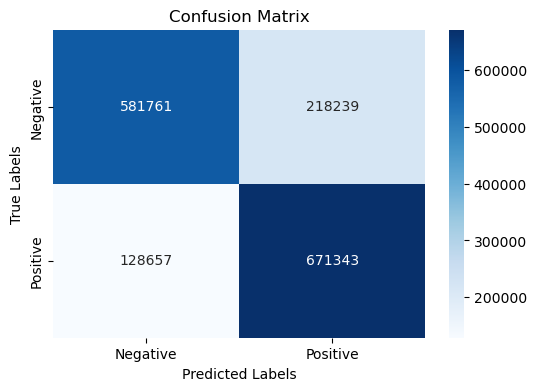

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Helpful resource: 
# https://www.w3schools.com/python/python_ml_confusion_matrix.asp#:~:text=In%20order%20to%20create%20the,metrics%20from%20the%20sklearn%20module.&text=Once%20metrics%20is%20imported%20we,our%20actual%20and%20predicted%20values.&text=To%20create%20a%20more%20interpretable,into%20a%20confusion%20matrix%20display.

# Generate the confusion matrix
conf_matrix = confusion_matrix(twitter_df["sentiment_num_conv"], corpus_label_pred)

# Create a heatmap to visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


#### Research Questions

- Which entities have the most positive or negative sentiment, on average? 

- What’s the relationship between sentiment and popularity?

- What are the most common entities in tweets associated with different sentiment labels?

- What types of entities are the most common? Which entity types are more associated with each sentiment label? 

- What's the relationship between length of tweets and their average sentiment?

In [27]:
####
# Tokenize tweet text
tweet_text = twitter_df["text"].values  
# tweet_text = corpus_sample["text"].values
tweet_tokenized = [tokenizer.tokenize(tweet) for tweet in tweet_text]
corpus_tweets_clean = [_remove_airline_tok(tokens) for tokens in tweet_tokenized]

# Convert tokenized tweets into strings that tf-idf vectorizer can actually use
corpus_tweets_clean_joined = [' '.join(tokens) for tokens in corpus_tweets_clean]
####

# train_tweets_tfidf = vectorizer.fit_transform(train_tweets_clean_joined)
corpus_tweets_tfidf = vectorizer.transform(corpus_tweets_clean_joined)


# Get predictions then evaluate performance on test set
corpus_label_pred = lr.predict(corpus_tweets_tfidf)
print(classification_report(twitter_df["sentiment_num_conv"], corpus_label_pred))
# print(classification_report(corpus_sample["sentiment_num_conv"], corpus_label_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77    800000
           1       0.75      0.84      0.79    800000

    accuracy                           0.78   1600000
   macro avg       0.79      0.78      0.78   1600000
weighted avg       0.79      0.78      0.78   1600000



### Which entities have the most positive or negative sentiment, on average???

Note: I decided to exclude entities that have an average sentiment score of exactly 0 (negative) or 1 (positive) to avoid tweets that only appear once in a negative or positive tweet from messing with the results.

Looking at the 10 entities with the highest and lowest average sentiments, we can see that the labels created by the logistic regression model and the ground truth labels that came with the corpus give us different results. However, there are a few commonalities. For the positive entities, variations on "FollowFriday" appear both logistic-regression and ground-truth label groups. For negative entities, spansl like "F*CK*" and "Boo Hoo" appear in the top 10 negative entities lists for both label sources as well. 

For the logistic regression group, it seems that the top 10 negative entities are WAY more common than their positive counterparts on average (129.9 tweets on avg for negative vs 50.4 for positive). This might be explained by the extremely high number of tweets that the negative span "UGH" appears in (724 different tweets). However, it's different for the ground truth labels, where the average number of tweets the top 10 most positive entities occur in is slightly higher than the negative side (32.1 vs 26.8 for negative).

The most interesting thing I observed here: I'm surprised "UGH" isn't included as one of the top 10 negative entities for the ground-truth labels. That's a very negative term!

In [28]:
# Initialize counter to track how many tweets an entity appears in
entity_doc_count = Counter()

# Iterate over each document and count spans 
for doc in doc_web:
    # Use set to make sure each entity only gets counted once per tweet
    seen_entities = set()
    for ent in doc.ents:
        if ent.text not in seen_entities:
            entity_doc_count.update([ent.text])  # Entity appears in this tweet
            seen_entities.add(ent.text)  # Mark entity as seen (in this tweet)

# Get top 10 most common spans from the filtered entities
items = entity_doc_count.items()
sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
most_common_ents = sorted_items[:10]

# Initialize dictionary to track sentiment for each entity
entity_sentiments = {}

# Method to calculate average sentiment for entities and determine most positive/negative ones
def get_avg_sents(label_source):
    # Connect each tweet in doc_web with its predicted sentiment
    for i, (doc, sentiment) in enumerate(zip(doc_web, label_source)): 
        for ent in doc.ents:
            if ent.text in entity_doc_count:
                

                # Store sentiment for the entity in the dictionary
                if ent.text not in entity_sentiments:
                    entity_sentiments[ent.text] = []  # Initialize the list for this entity
                entity_sentiments[ent.text].append(sentiment)  # Append sentiment value

    # Get avg sentiment for the filtered entities
    entity_avg_sentiments = {}
    for entity, sentiments in entity_sentiments.items():
        avg_sentiment = np.mean(sentiments)  # Calculate the mean sentiment for each entity
        entity_avg_sentiments[entity] = avg_sentiment  # Store the average sentiment

    # Filter out entities where avg sentiment = 0 or = 1
    filtered_avg_sentiments = {entity: avg_sentiment for entity, avg_sentiment in entity_avg_sentiments.items()
                               if avg_sentiment != 0 and avg_sentiment != 1}

    # Sort entities by avg sentiment (highest to lowest)
    items = filtered_avg_sentiments.items()
    sorted_entities = sorted(items, key=lambda x: x[1], reverse=True)

    
    print("\nTop 10 Most Positive Entities (excluding sentiment = 0 or 1):")
    sum_pos_tweets = 0
    for entity, avg_sentiment in sorted_entities[:10]:  # Top 10 most positive
        tweet_count = entity_doc_count[entity]
        sum_pos_tweets += tweet_count
        print(f"  - {entity}: {tweet_count} tweets || Average Sentiment = {round(avg_sentiment, 2)}")
        
    avg_positive_tweets = sum_pos_tweets / 10  # Calculate average tweet count
    print(f"\nAverage Number of Tweets for Top 10 Positive Entities: {round(avg_positive_tweets, 2)}")

    print("\nTop 10 Most Negative Entities (excluding sentiment = 0 or 1):")
    sum_neg_tweets = 0
    for entity, avg_sentiment in sorted_entities[-10:]:  # Bottom 10 most negative
        tweet_count = entity_doc_count[entity]
        sum_neg_tweets += tweet_count
        print(f"  - {entity}: {tweet_count} tweets || Average Sentiment = {round(avg_sentiment, 2)}")
    
    avg_neg_tweets = sum_neg_tweets / 10  # Calculate average tweet count
    print(f"\nAverage Number of Tweets for Top 10 Negative Entities: {round(avg_neg_tweets, 2)}")


# Run the function to get the entities with the most positive and negative sentiment
print("Entities with the most positive and negative sentiment (logistic regression prediction):")
get_avg_sents(corpus_label_pred)
print()
print("Entities with the most positive and negative sentiment (twitter_df ground truth):")
get_avg_sents(twitter_df["sentiment_num_conv"])


Entities with the most positive and negative sentiment (logistic regression prediction):

Top 10 Most Positive Entities (excluding sentiment = 0 or 1):
  - Sweet Dreams: 84 tweets || Average Sentiment = 0.99
  - #followfriday: 78 tweets || Average Sentiment = 0.99
  - Ð: 55 tweets || Average Sentiment = 0.98
  - followfriday: 54 tweets || Average Sentiment = 0.98
  - YUMMY: 48 tweets || Average Sentiment = 0.98
  - ÐºÐ: 43 tweets || Average Sentiment = 0.98
  - #ff: 39 tweets || Average Sentiment = 0.97
  - Yum: 36 tweets || Average Sentiment = 0.97
  - VINES: 34 tweets || Average Sentiment = 0.97
  - @joelmadden: 33 tweets || Average Sentiment = 0.97

Average Number of Tweets for Top 10 Positive Entities: 50.4

Top 10 Most Negative Entities (excluding sentiment = 0 or 1):
  - RIP Farrah: 29 tweets || Average Sentiment = 0.03
  - UGH: 724 tweets || Average Sentiment = 0.03
  - Boo hoo: 32 tweets || Average Sentiment = 0.03
  - worst day: 32 tweets || Average Sentiment = 0.03
  - eurgh:

### What’s the relationship between sentiment and popularity???
Based on the top 10 most common spans, there doesn't really seem to be a relationship! If a label of 0 = negative sentiment and a 1 = positive sentiment, then on average, entities that appear in more positive tweets would have a sentiment closer to 1. Lookin at the top 10 most common spans and their average sentiments, we get this:

Top 10 most common entity spans and their average sentiment (logistic regression prediction):
  - today: 57597 instances || Average sentiment = 0.46
  - tomorrow: 27349 instances || Average sentiment = 0.45
  - 2: 26003 instances || Average sentiment = 0.49
  - tonight: 23124 instances || Average sentiment = 0.52
  - one: 14757 instances || Average sentiment = 0.6
  - first: 12105 instances || Average sentiment = 0.69
  - 4: 9864 instances || Average sentiment = 0.55
  - last night: 9733 instances || Average sentiment = 0.43
  - morning: 8907 instances || Average sentiment = 0.78
  - yesterday: 8535 instances || Average sentiment = 0.43

Top 10 most common entity spans and their average sentiment (twitter_df ground truth):
  - today: 57597 instances || Average sentiment = 0.45
  - tomorrow: 27349 instances || Average sentiment = 0.44
  - 2: 26003 instances || Average sentiment = 0.46
  - tonight: 23124 instances || Average sentiment = 0.5
  - one: 14757 instances || Average sentiment = 0.56
  - first: 12105 instances || Average sentiment = 0.64
  - 4: 9864 instances || Average sentiment = 0.52
  - last night: 9733 instances || Average sentiment = 0.41
  - morning: 8907 instances || Average sentiment = 0.72
  - yesterday: 8535 instances || Average sentiment = 0.42

It looks like, aside from "one," "first," and "morning," the ten most common entity spans generally have average sentiment scores around 0.5 or slightly below it! It seems that an entity being more common or popular doesn't make it related to more positive or negative discussions. Another note is that the average sentiments generated from the sentiment predictions from the logistic regression model tend to be a bit higher than the averages generated from ground truth sentiment labels for the top 10 most common entities (ex: "morning" has an average sentiment of 0.78 according to the logistic regression labels, but a 0.72 based on ground truth sentiment labels).


In [29]:
# Initialize entity span counter
entity_spans = Counter()

# Iterate over each tweet and count spans
for doc in doc_web:
    for ent in doc.ents:
        entity_spans.update([ent.text])  

# Get top 10 most common spans
most_common_ents = entity_spans.most_common(10)

# Print the top 10 most common spans with their counts
print("Top 10 most common entity spans:")
for span, count in most_common_ents:
    print(f"  - {span}: {count} instances")

Top 10 most common entity spans:
  - today: 57597 instances
  - tomorrow: 27349 instances
  - 2: 26003 instances
  - tonight: 23124 instances
  - one: 14757 instances
  - first: 12105 instances
  - 4: 9864 instances
  - last night: 9733 instances
  - morning: 8907 instances
  - yesterday: 8535 instances


In [30]:
# Get the average sentiment associated with each of the top 10 most common spans

# Initialize entity span counter and dictionary to track sentiment for each entity
# entity_spans = Counter() COMM
entity_sentiments = {}

# Method for iterating through doc web and finding average of its sentiment across all tweets
# Parameter "label_source" defines if you want the to use sentiment labels predicted by model, or the ground truth
# from twitter_df
def get_avg_sents(label_source):
    # Connect each tweet in doc_web with its predicted sentiment
    for i, (doc, sentiment) in enumerate(zip(doc_web, label_source)): 
        for ent in doc.ents:
            
            # Store sentiment for the entity in the dictionary
            if ent.text not in entity_sentiments:
                entity_sentiments[ent.text] = []  # Create list for the entity
            entity_sentiments[ent.text].append(sentiment)  # Add sentiments to list


    for span, count in most_common_ents:
        avg_sentiment = np.mean(entity_sentiments[span])  # Average of sentiment values

        # Silly but helpful resource: https://www.geeksforgeeks.org/round-function-python/
        print(f"  - {span}: {count} instances || Average sentiment = {round(avg_sentiment, 2)}")

print("Top 10 most common entity spans and their average sentiment (logistic regression prediction):")
get_avg_sents(corpus_label_pred)
print()
print("Top 10 most common entity spans and their average sentiment (twitter_df ground truth):")
get_avg_sents(twitter_df["sentiment_num_conv"])

Top 10 most common entity spans and their average sentiment (logistic regression prediction):
  - today: 57597 instances || Average sentiment = 0.46
  - tomorrow: 27349 instances || Average sentiment = 0.45
  - 2: 26003 instances || Average sentiment = 0.49
  - tonight: 23124 instances || Average sentiment = 0.52
  - one: 14757 instances || Average sentiment = 0.6
  - first: 12105 instances || Average sentiment = 0.69
  - 4: 9864 instances || Average sentiment = 0.55
  - last night: 9733 instances || Average sentiment = 0.43
  - morning: 8907 instances || Average sentiment = 0.78
  - yesterday: 8535 instances || Average sentiment = 0.43

Top 10 most common entity spans and their average sentiment (twitter_df ground truth):
  - today: 57597 instances || Average sentiment = 0.45
  - tomorrow: 27349 instances || Average sentiment = 0.44
  - 2: 26003 instances || Average sentiment = 0.46
  - tonight: 23124 instances || Average sentiment = 0.5
  - one: 14757 instances || Average sentiment =

<Figure size 800x500 with 0 Axes>

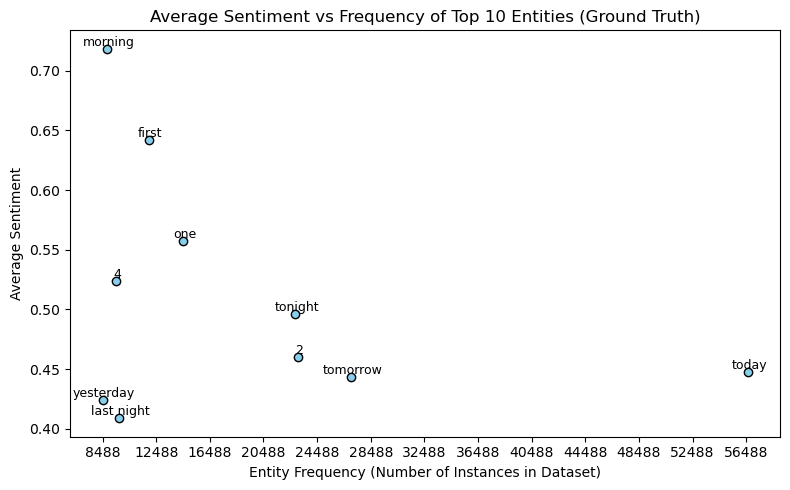

In [44]:

# Average sentiment values are really similar for both predicted and ground truth labels, so just show ground truth

# Get the top 10 most common entities based on their occurrence count
top_10_entities = entity_doc_count.most_common(10)

# Initialize the lists for plotting for ground truth
top_10_counts_truth = []
top_10_avg_sentiments_truth = []

# Calculate the average sentiment for each of the top 10 entities for ground truth labels
for entity, _ in top_10_entities:
    if entity in entity_sentiments:
        avg_sentiment_truth = np.mean(entity_sentiments[entity]) 
        top_10_counts_truth.append(entity_doc_count[entity])  # Entity frequency (count)
        top_10_avg_sentiments_truth.append(avg_sentiment_truth)  # Average sentiment for each entity


# Making a scatterplot
plt.figure(figsize=(8, 5))

# Adding labels for entity
# Helpful resource: 
# https://medium.com/@marvelouskgc/three-ways-to-add-labels-to-each-data-point-in-a-scatter-plot-in-python-matplotlib-eugene-tsai-42e4094dc07e
plt.figure(figsize=(8, 5))
for i, entity in enumerate(top_10_entities):
    plt.text(top_10_counts_truth[i] + 100, top_10_avg_sentiments_truth[i],  # Adjust position to avoid overlap
             entity[0],  # Entity name
             fontsize=9,  
             ha='center',  # Horizontal alignment
             va='bottom')  # Vertical alignment
             

# Scatter plot for the ground truth labels (from twitter_df)
plt.scatter(top_10_counts_truth, top_10_avg_sentiments_truth, color='skyblue', edgecolors='black')
plt.xlabel('Entity Frequency (Number of Instances in Dataset)')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment vs Frequency of Top 10 Entities (Ground Truth)')

# Adjust the x-axis to automatically show frequencies for the plot
min_count_truth = min(top_10_counts_truth)
max_count_truth = max(top_10_counts_truth)
plt.xticks(np.arange(min_count_truth, max_count_truth + 1, step=4000))  # Adjust step as needed

# Remove gridlines
plt.grid(False)

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### What are the most common entities in tweets associated with different sentiment labels???

It seems that across both positive and negative tweets, regardless of which label source we're using (logistic regression prediction vs ground truth), the same spans are the most common across the board! "Today" is the most commonly occurring entity across tweets of all sentiments and label sources, and other entities like "2", "tomorrow", and "tonight" are very common as well. However, there are some entities that only appear in the top 10 frequency list for either the positive or sentiment label class. For example "LOL" only appears in the top 10 list for entities with positive sentiment, while "yesterday" only appears in the otp 10 list for entities with negative sentiment. The top 10 entities for each sentiment label are pretty consistent aross both the logistic regression labels and ground truth labels, so it seems that the most common entities are so common that the differences in label performance don't really make a difference in this case.

In [32]:
# Splitting doc_web by sentiment and counting by spans
def count_entity_spans_by_sentiment(doc_web, label_source):
    
    # Initialize positive and negative entity counters
    positive_entity_spans = Counter()
    negative_entity_spans = Counter()

    # Iterate over each document + sentiment label
    for doc, sentiment in zip(doc_web, label_source):
        if sentiment == 1: # Positive
            for ent in doc.ents:
                positive_entity_spans.update([ent.text])
        elif sentiment == 0:
            for ent in doc.ents:
                negative_entity_spans.update([ent.text])
    
    # Get the most common entity spans for positive and negative sentiments
    print("\nTop 10 Most Common Entity Spans (Positive Sentiment):")
    most_common_positive_ents = positive_entity_spans.most_common(10)
    for span, count in most_common_positive_ents:
        print(f"  - {span}: {count} instances")
    
    print("\nTop 10 Most Common Entity Spans (Negative Sentiment):")
    most_common_negative_ents = negative_entity_spans.most_common(10)
    for span, count in most_common_negative_ents:
        print(f"  - {span}: {count} instances")

print("Logistic Regression Prediction Labels:")
count_entity_spans_by_sentiment(doc_web, corpus_label_pred)
print()
print("Ground Truth Sentiment Labels:")
count_entity_spans_by_sentiment(doc_web, twitter_df["sentiment_num_conv"])


Logistic Regression Prediction Labels:

Top 10 Most Common Entity Spans (Positive Sentiment):
  - today: 26730 instances
  - 2: 12816 instances
  - tomorrow: 12306 instances
  - tonight: 11916 instances
  - one: 8908 instances
  - first: 8365 instances
  - morning: 6950 instances
  - LOL: 6149 instances
  - #: 5633 instances
  - 4: 5469 instances

Top 10 Most Common Entity Spans (Negative Sentiment):
  - today: 30867 instances
  - tomorrow: 15043 instances
  - 2: 13187 instances
  - tonight: 11208 instances
  - one: 5849 instances
  - last night: 5558 instances
  - yesterday: 4900 instances
  - 4: 4395 instances
  - 3: 4268 instances
  - first: 3740 instances

Ground Truth Sentiment Labels:

Top 10 Most Common Entity Spans (Positive Sentiment):
  - today: 24854 instances
  - tomorrow: 11929 instances
  - 2: 11115 instances
  - tonight: 11015 instances
  - one: 7548 instances
  - first: 7168 instances
  - morning: 5845 instances
  - LOL: 5597 instances
  - #: 4906 instances
  - 4: 4864 

#### What types of entities are the most common? Which entity types are more associated with each sentiment label???

Across both the predicted and ground truth labels, the top three most common entity types for positive tweets are "PERSON", "ORG", and "DATE". The top three most common entity types for negative tweets are "DATE", "PERSON", and "ORG". It's interesting that the top entity type in positive tweets is "PERSON," but the most common entity type in negative tweets is "DATE"! 

The 4th-9th most common entity types is the same across both label classes as well, but the 10th most common entity type changed. For positive tweets, it was "WORK_OF_ART," while for negative tweets the 10th most common entity type was "MONEY". IT seems that people are happier when they tweet about works of art than they are when they tweet abount money!

In [33]:
# Function to count entity types in a single document
def count_entity_types(doc):
    entity_types = [ent.label_ for ent in doc.ents]
    return Counter(entity_types)

entity_counts = doc_web.apply(count_entity_types)

# Convert to dataframe to make summarizing easier
entity_counts_df = pd.DataFrame(list(entity_counts))

# Find the sum of instances for each entity type
sum_entity_counts = entity_counts_df.sum()

print(sum_entity_counts)


PERSON         344579.0
DATE           291742.0
ORG            305084.0
PERCENT          2850.0
ORDINAL         26742.0
CARDINAL       158404.0
LOC             11457.0
TIME           114966.0
GPE            138184.0
NORP            36439.0
QUANTITY         5938.0
WORK_OF_ART     12484.0
FAC              8745.0
MONEY           13660.0
PRODUCT         16398.0
LANGUAGE         3032.0
EVENT            2842.0
LAW              1487.0
dtype: float64


In [34]:
# Splitting doc_web by sentiment and counting by entity types
def count_entity_types_by_sentiment(doc_web, label_source):
    
    # Initialize positive and negative entity type counters
    positive_entity_types = Counter()
    negative_entity_types = Counter()

    # Iterate over each document + sentiment label
    for doc, sentiment in zip(doc_web, label_source):
        if sentiment == 1:  # Positive
            for ent in doc.ents:
                positive_entity_types.update([ent.label_])  # Use entity type
        elif sentiment == 0:  # Negative
            for ent in doc.ents:
                negative_entity_types.update([ent.label_])  # Use entity type
    
    # Get the most common entity types for positive and negative sentiments
    print("\nTop 10 Most Common Entity Types (Positive Sentiment):")
    most_common_positive_types = positive_entity_types.most_common(10)
    for entity_type, count in most_common_positive_types:
        print(f"  - {entity_type}: {count} instances")
    
    print("\nTop 10 Most Common Entity Types (Negative Sentiment):")
    most_common_negative_types = negative_entity_types.most_common(10)
    for entity_type, count in most_common_negative_types:
        print(f"  - {entity_type}: {count} instances")

print("Logistic Regression Prediction Labels:")
count_entity_types_by_sentiment(doc_web, corpus_label_pred)
print()
print("Ground Truth Sentiment Labels:")
count_entity_types_by_sentiment(doc_web, twitter_df["sentiment_num_conv"])


Logistic Regression Prediction Labels:

Top 10 Most Common Entity Types (Positive Sentiment):
  - PERSON: 218269 instances
  - ORG: 187922 instances
  - DATE: 145081 instances
  - CARDINAL: 87313 instances
  - GPE: 82267 instances
  - TIME: 58310 instances
  - NORP: 23362 instances
  - ORDINAL: 17113 instances
  - PRODUCT: 10401 instances
  - WORK_OF_ART: 9423 instances

Top 10 Most Common Entity Types (Negative Sentiment):
  - DATE: 146661 instances
  - PERSON: 126310 instances
  - ORG: 117162 instances
  - CARDINAL: 71091 instances
  - TIME: 56656 instances
  - GPE: 55917 instances
  - NORP: 13077 instances
  - ORDINAL: 9629 instances
  - PRODUCT: 5997 instances
  - MONEY: 5550 instances

Ground Truth Sentiment Labels:

Top 10 Most Common Entity Types (Positive Sentiment):
  - PERSON: 194550 instances
  - ORG: 168014 instances
  - DATE: 133217 instances
  - CARDINAL: 75044 instances
  - GPE: 71499 instances
  - TIME: 52307 instances
  - NORP: 20339 instances
  - ORDINAL: 14728 instan

### What's the relationship between length of tweets and their average sentiment?
It seems that there's some fluctuation around the 20-40 range, but as the length of a tweet goes beyond 40 words, the average sentiment of the tweet starts to increase. Loooking at groud truth labels, the average sentiment for the shortest group is 0.51 and goes as high as 0.78 for tweets in the 80+ words range. That correlation is more pronounced when using predicted labels, as the average sentiments jump from 0.57 to as high as 0.95 between the shortest and longest tweet groups when assessing using predicted sentiment labels.

Average sentiment by tweet length category (logistic predictions):
length_category
20 words or less    0.570754
40 words or less    0.513586
60 words or less    0.777950
80 words or less    0.928030
80 words+           0.950472
Name: corpus_label_pred, dtype: float64

Average sentiment by tweet length category (ground truth):
length_category
20 words or less    0.510553
40 words or less    0.469878
60 words or less    0.580745
80 words or less    0.662879
80 words+           0.783019
Name: sentiment_num_conv, dtype: float64


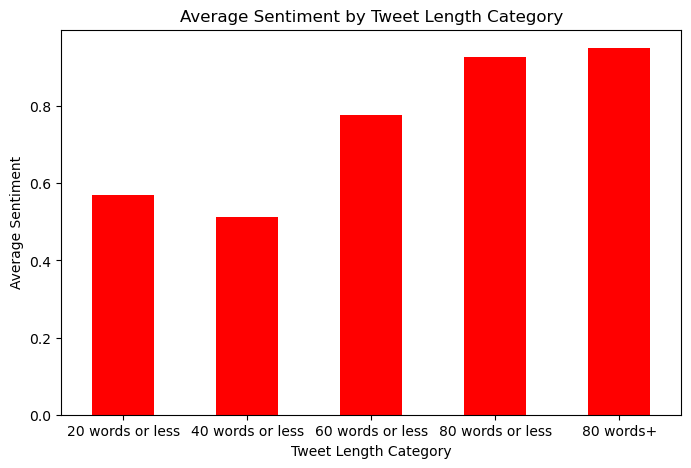

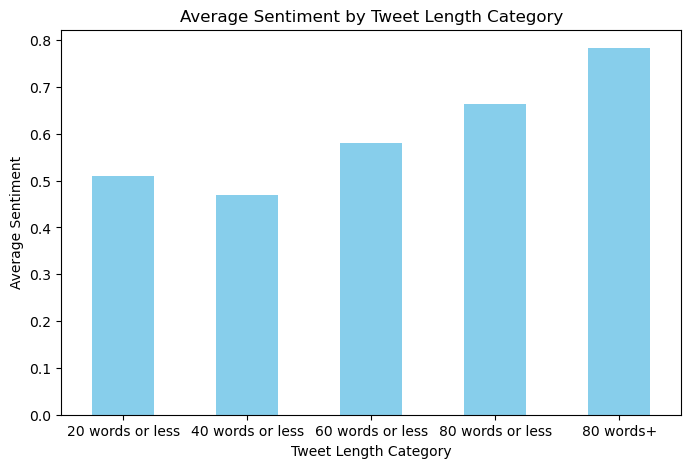

In [35]:
# Calculate tweet lengths
len_arr = [len(tweet) for tweet in clean_tweets]
twitter_df['tweet_length'] = len_arr  # Add tweet length as a new column

# Group tweets into different lengths
def categorize_length(length):
    if length <= 20:
        return '20 words or less'
    elif length <= 40:
        return '40 words or less'
    elif length <= 60:
        return '60 words or less'
    elif length <= 80:
        return '80 words or less'
    else:
        return '80 words+'

# Add a new column for length category for each tweet in twitter_df
twitter_df['length_category'] = twitter_df['tweet_length'].apply(categorize_length)

# Calculate average sentiment for each tweet length category using predicted lables
twitter_df['corpus_label_pred'] = corpus_label_pred  # Add predictions as a column to make next steps easier
avg_sentiment_by_length_pred = twitter_df.groupby('length_category')['corpus_label_pred'].mean()
print("Average sentiment by tweet length category (logistic predictions):")
print(avg_sentiment_by_length_pred)

print()
# Calculate average sentiment for each tweet length category using ground truth labels
avg_sentiment_by_length_truth = twitter_df.groupby('length_category')['sentiment_num_conv'].mean()
print("Average sentiment by tweet length category (ground truth):")
print(avg_sentiment_by_length_truth)


# Helpful resource: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
# Bar plot (predicted labels)
plt.figure(figsize=(8, 5))
avg_sentiment_by_length_pred.plot(kind='bar', color='red')
plt.title("Average Sentiment by Tweet Length Category")
plt.xlabel("Tweet Length Category")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=0)
plt.show()

# Bar plot (ground truth labels)
plt.figure(figsize=(8, 5))
avg_sentiment_by_length_truth.plot(kind='bar', color='skyblue')
plt.title("Average Sentiment by Tweet Length Category")
plt.xlabel("Tweet Length Category")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=0)
plt.show()